# Yasur Volcano temporary deployment, summer 2016
---

This example notebook calculates and plots paths for Yasur infrasound stations. Compare the plots to [Fig. 4b,c](https://gsw.silverchair-cdn.com/gsw/Content_public/Journal/tsr/2/3/10.1785_0320220019/1/0320220019fig4.png?Expires=1664526744&Signature=ypGEf~vz~bWBNZYmBUgIc72yCdDz40TCWiaHMhVgniiomEsQO4kzjgw0smR19bt6Eq0a5H-ecfoEijOV-dAc3zzYHZdkThBMWnfaPTF4Kz0BCzZ2tNYZVtK8aYDkysxc6YdG6wfPGNrrIvCZLZsWXFn~L8QlTAeRkTeIPn8DnnVgdoqMtyifAEbmfVMoEJLZDc~2z9pcLuOl3X7-XGsR~eE9~5J7tiX0MU11FLKc-3ZpCRcwSYG5UXRhcf0C6et1IRkseRFguBHt0650lRiqP3sFZBM~8RFaHLvRQSOFN7Hl9S3Xs2TvfDHRqtegkc87h8z9cfm4XcZk98IjV4noyQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA) in Toney et al. (2022).

## References

Toney, L., Fee, D., Witsil, A., & Matoza, R. S. (2022). Waveform features
strongly control subcrater classification performance for a large, labeled
volcano infrasound dataset. *The Seismic Record*, *2*(3), 167–175.
https://doi.org/10.1785/0320220019

## Set up and calculate paths

In [1]:
from pathlib import Path
from urllib.request import urlretrieve

import pandas as pd

from infresnel import calculate_paths

# Load Yasur subcrater locations
SRC_URL = 'https://raw.githubusercontent.com/liamtoney/yasur_ml/main/yasur_subcrater_locs.json'
src_df = pd.read_json(SRC_URL)

# Load Yasur station coordinates
REC_URL = 'http://service.iris.edu/fdsnws/station/1/query?net=3E&sta=YIF?&format=geocsv'
rec_df = pd.read_csv(REC_URL, sep='|', comment='#')
rec_df = rec_df[rec_df.Station != 'YIF6']  # Don't include YIF6

# Download Yasur DEM, if it doesn't already exist (~200 MB GeoTIFF), and resample for speed/memory
DEM_URL = 'https://opentopography.s3.sdsc.edu/dataspace/OTDS.072019.4326.1/raster/DEM_WGS84.tif'
DEM_FILE = 'DEM_WGS84_resampled.tif'
RES = 0.000005  # [deg.]
if not Path(DEM_FILE).is_file():
    print('Downloading and resampling DEM...')
    !gdalwarp -tr {RES} {RES} -r cubicspline {urlretrieve(DEM_URL)[0]} {DEM_FILE}
    print('Done\n')

# Call function
ds_list, dem = calculate_paths(
    src_lat=src_df.S[1],
    src_lon=src_df.S[0],
    rec_lat=rec_df.Latitude,
    rec_lon=rec_df.Longitude,
    dem_file=DEM_FILE,
    full_output=True,
)

Creating output file that is 2533P x 2598L.
Processing /var/folders/vr/y2n71p290zzgzbzp8xzl0ykw0000gn/T/tmpsiqysrth [1/1] : 0Using internal nodata values (e.g. 0) for image /var/folders/vr/y2n71p290zzgzbzp8xzl0ykw0000gn/T/tmpsiqysrth.
Copying nodata values from source /var/folders/vr/y2n71p290zzgzbzp8xzl0ykw0000gn/T/tmpsiqysrth to destination DEM_WGS84_resampled.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Done

Loading and projecting DEM...
Done

DEM spacing = 0.54 m -> profile spacing = 0.27 m

Fitting spline to DEM...
Done

Computing 5 paths...


  0% |          | 0/5 paths 

Done


## Create example figures (optional)

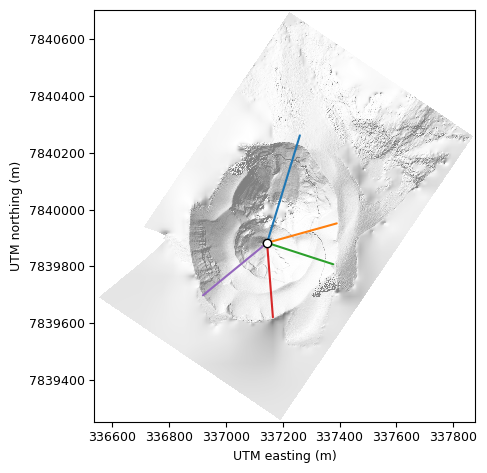

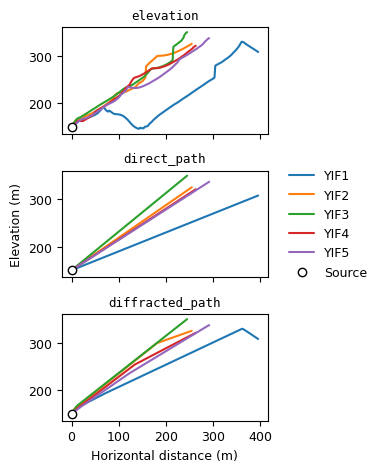

In [2]:
import matplotlib
import matplotlib.pyplot as plt

SAVE_EXAMPLE_FIGURES = False

# Reset everything to defaults; use smaller font size
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('font', size=9)

# Plot DEM with source-receiver paths
fig, ax = plt.subplots()
hs = dem.copy()
hs.data = matplotlib.colors.LightSource().hillshade(
    dem.data,
    dx=abs(dem.x.diff('x').mean().values),
    dy=abs(dem.y.diff('y').mean().values),
)
hs.plot.imshow(ax=ax, cmap='Greys_r', alpha=0.5, add_colorbar=False, add_labels=False)
for ds, station in zip(ds_list, rec_df.Station):
    ax.plot(ds.x, ds.y, solid_capstyle='round', label=station)
ax.scatter(ds.x[0], ds.y[0], c='white', ec='black', zorder=2, label='Source')
ax.ticklabel_format(style='plain')
ax.set_aspect('equal')
ax.set_xlabel('UTM easting (m)')
ax.set_ylabel('UTM northing (m)')
# ax.legend(loc='center left', frameon=False, bbox_to_anchor=(1.05, 0.5))
fig.tight_layout()
plt.show()
if SAVE_EXAMPLE_FIGURES:
    fig.savefig('../example_figures/yasur_dem_paths.png', bbox_inches='tight', dpi=300)

# Plot comparison of elevation profiles, direct paths, and shortest diffracted paths
fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True)
for ax, var_name in zip(axes, ds_list[0].data_vars):
    for ds, station in zip(ds_list, rec_df.Station):
        ax.plot(ds.distance, ds[var_name], solid_capstyle='round', label=station)
    ax.scatter(
        ds.distance[0], ds.elevation[0], c='white', ec='black', zorder=2, label='Source'
    )
    ax.set_title(var_name, fontsize='medium', fontname='monospace')
    ax.set_aspect('equal')
axes[-1].set_xlabel('Horizontal distance (m)')
axes[1].set_ylabel('Elevation (m)')
axes[1].legend(loc='center left', frameon=False, bbox_to_anchor=(1.05, 0.5))
fig.tight_layout()
plt.show()
if SAVE_EXAMPLE_FIGURES:
    fig.savefig(
        '../example_figures/yasur_path_comparison.png', bbox_inches='tight', dpi=300
    )